# Training
This notebook contains sample code to show how to train a model step by step. A full training script is available in `scripts/experiment.py`.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import seaborn as sns
import time
import torch
import tqdm.auto as tqdm
import ttpp

from copy import deepcopy
sns.set_style('whitegrid')
# Comment this line out if no GPU is available
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Load a dataset and split it
Available datasets can be returned by `ttpp.data.list_datasets()`

In [2]:
dset = ttpp.data.load_dataset('taxi')
d_train, d_val, d_test = dset.train_val_test_split(train_size=0.6, val_size=0.2, test_size=0.2)
dl_train = torch.utils.data.DataLoader(d_train, batch_size=len(d_train), shuffle=False)
dl_val = torch.utils.data.DataLoader(d_val, batch_size=len(d_val), shuffle=False)
dl_test = torch.utils.data.DataLoader(d_test, batch_size=len(d_test), shuffle=False)

### Init a model
Change your model parameters here or use a different model like `ttpp.models.Autoregressive` for the RNN model.

In [3]:
model = ttpp.models.TriTPP(dset.t_max,  # Keep this as is
                           lambda_init=d_train.mean_number_items,  # Keep this as is
                           n_knots=10, 
                           n_blocks=2, 
                           block_size=4)

### Training

In [4]:
# Optimization params
max_epoch = 5000
learning_rate = 0.01
weight_decay = 1e-5
threshold = 1e-4
patience = 100

In [5]:
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=100, verbose=True)

In [6]:
losses = []
val_losses = []
best_loss, best_train = np.inf, np.inf
best_model = deepcopy(model)
with tqdm.trange(max_epoch) as progress:
    for epoch in progress:
        # Optimization
        model.train()
        for x, mask in dl_train:
            opt.zero_grad()
            loss = -(model.log_prob(x, mask)/d_train.mean_number_items).mean()
            loss.backward()
            opt.step()
            
        loss = loss.item()
        losses.append(loss)

        lr_scheduler.step(loss)
        
        # Validation
        x, mask = next(iter(dl_val))
        val_loss = -(model.log_prob(x, mask)/d_train.mean_number_items).mean().item()
        val_losses.append(val_loss)
        
        # Early stopping
        if (best_loss - val_loss) < threshold:
            impatient += 1
            if val_loss < best_loss:
                best_train, best_loss = loss, val_loss
                best_model = deepcopy(model)
        else:
            best_train, best_loss = loss, val_loss
            best_model = deepcopy(model)
            impatient = 0

        if impatient >= patience:
            print(f'Breaking due to early stopping at epoch {epoch}')
            break
        
        # Progress update
        progress.set_postfix({
            'Loss': loss,
            'Val loss': val_loss
        })

Breaking due to early stopping at epoch 220



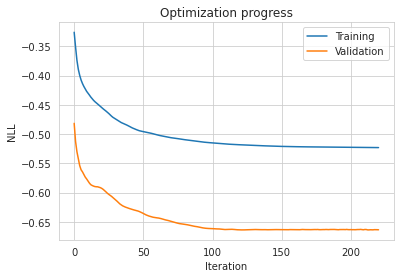

In [7]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)
plt.title('Optimization progress')
plt.xlabel('Iteration')
plt.ylabel('NLL')
plt.legend(['Training', 'Validation'])
plt.show()

# MMD

In [8]:
# More samples increase the accuracy of MMD but increase computational complexity quadratically
n_samples = 4000
# Sample from the model 
# pick max_seq_len large enough to make sure that the [0, T] interval is covered
max_seq_len = 10 * d_train.times.shape[1] 
with torch.no_grad():
    X = model.rsample(n_samples, init_seq_len=200).clamp(max=dset.t_max).cpu().numpy()
# You may cahnge dl_val to dl_test to get results for the test_set
Y = next(iter(dl_val))[0].detach().cpu().numpy()
# Compute the MMD
mmd, sigma = ttpp.metrics.MMD(X, Y, dset.t_max)
print('MMD', mmd)

MMD 0.09285936393907232
